In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/MEIA2025'

LABELS_CSV = f'{BASE_PATH}/labels/labels.csv'
TEST_CSV = f'{BASE_PATH}/labels/test.csv'
IMG_FOLDER = f'{BASE_PATH}/images'

In [ ]:
import os

print(os.path.exists(LABELS_CSV))
print(os.path.exists(TEST_CSV))
print(os.path.exists(IMG_FOLDER))

True
True
True


In [ ]:
def load_checkpoint(model, optimizer, filename='best_sargazo_model.pth'):
    if os.path.exists(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_f1 = checkpoint['f1_score']
        print(f"Resuming from epoch {start_epoch} with F1: {best_f1:.4f}")
        return start_epoch, best_f1
    return 0, 0.0

Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 62.6MB/s]



Epoch 1/50
train Loss: 1.1381 | F1: 0.5017
val Loss: 1.1364 | F1: 0.5284

Epoch 2/50
train Loss: 0.9822 | F1: 0.5847
val Loss: 1.0908 | F1: 0.5538

Epoch 3/50
train Loss: 0.9438 | F1: 0.6003
val Loss: 1.0237 | F1: 0.5738

Epoch 4/50
train Loss: 0.9193 | F1: 0.6013
val Loss: 0.9802 | F1: 0.5961

Epoch 5/50
train Loss: 0.8782 | F1: 0.6304
val Loss: 0.9798 | F1: 0.6097

Epoch 6/50
train Loss: 0.8702 | F1: 0.6313
val Loss: 1.0181 | F1: 0.5880

Epoch 7/50
train Loss: 0.8206 | F1: 0.6687
val Loss: 1.0416 | F1: 0.5789

Epoch 8/50
train Loss: 0.8327 | F1: 0.6554
val Loss: 0.9273 | F1: 0.6199

Epoch 9/50
train Loss: 0.8035 | F1: 0.6796
val Loss: 0.9845 | F1: 0.6029

Epoch 10/50
train Loss: 0.7947 | F1: 0.6737
val Loss: 0.9604 | F1: 0.6534

Epoch 11/50
train Loss: 0.7881 | F1: 0.6792
val Loss: 1.0971 | F1: 0.5908

Epoch 12/50
train Loss: 0.7574 | F1: 0.6919
val Loss: 1.0201 | F1: 0.6114

Epoch 13/50
train Loss: 0.7339 | F1: 0.6990
val Loss: 1.0028 | F1: 0.6189

Epoch 14/50
train Loss: 0.7423 | 

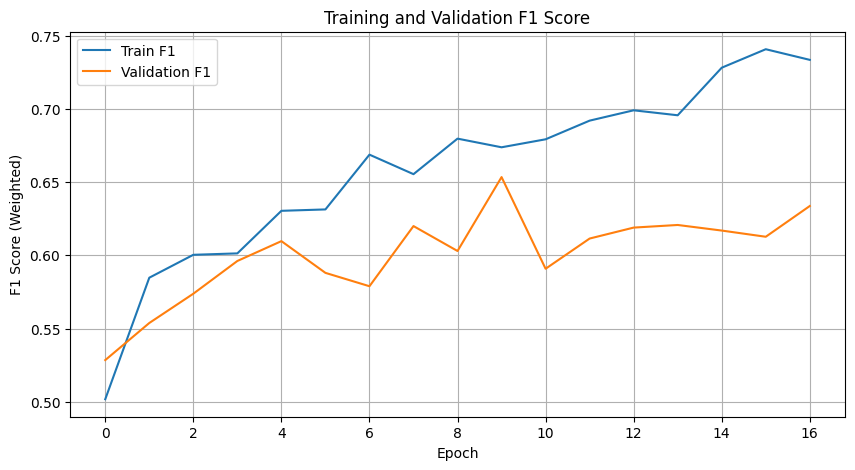

In [8]:
# Sargassum Amount Classification using MobileNetV2

# Model:
# - Backbone: MobileNetV2 (pretrained on ImageNet)
# - Task: Multiclass image classification (5 classes)
# - Metric: Weighted F1-score
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Regularization: Early Stopping
#
# Classes:
# - nada, bajo, moderado, abundante, excesivo



# IMPORTS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms


# CLASS MAPPINGS
class2id = {
    'nada': 0,
    'bajo': 1,
    'moderado': 2,
    'abundante': 3,
    'excesivo': 4
}
id2class = {v: k for k, v in class2id.items()}
num_classes = len(class2id)


# IMAGE TRANSFORMS
input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
}


# CUSTOM DATASET
class SargazoDataset(Dataset):
    """
    Custom PyTorch Dataset for sargassum image classification.
    """

    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = os.path.join(self.root_dir, img_name)

        image = Image.open(img_path).convert("RGB")

        label_str = self.dataframe.iloc[idx]['label'].strip().lower()
        label = class2id.get(label_str, class2id['nada'])

        if self.transform:
            image = self.transform(image)

        return image, label


# EARLY STOPPING
class EarlyStopping:
    """
    Stops training when validation F1 stops improving.
    """

    def __init__(self, patience=7, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        elif current_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_score
            self.counter = 0


# MODEL INITIALIZATION
def initialize_model():
    """
    Initializes MobileNetV2 with a custom classification head.
    """
    model = models.mobilenet_v2(
        weights=models.MobileNet_V2_Weights.DEFAULT
    )

    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    return model


# TRAINING LOOP
def train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    device,
    num_epochs=30,
    patience=7
):
    """
    Trains the model using train/validation phases and early stopping.
    """

    best_model_wts = model.state_dict()
    best_f1 = 0.0

    early_stopping = EarlyStopping(patience=patience)

    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_preds = []
            running_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(
                running_labels,
                running_preds,
                average='weighted'
            )

            print(f"{phase} Loss: {epoch_loss:.4f} | F1: {epoch_f1:.4f}")

            if phase == 'val':
                val_f1_history.append(epoch_f1)

                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = model.state_dict()

                early_stopping(epoch_f1)
                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    model.load_state_dict(best_model_wts)
                    return model, train_f1_history, val_f1_history
            else:
                train_f1_history.append(epoch_f1)

    model.load_state_dict(best_model_wts)
    return model, train_f1_history, val_f1_history


# PREDICTION FUNCTION
def predict(model, dataloader, device):
    """
    Generates predictions for a given dataloader.
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

    return predictions

# DATA LOADING
labels_df = pd.read_csv(LABELS_CSV)
test_df = pd.read_csv(TEST_CSV)

# Stratified split to preserve class distribution
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    random_state=42,
    stratify=labels_df['label']
)

train_dataset = SargazoDataset(
    train_df, IMG_FOLDER, data_transforms['train']
)
val_dataset = SargazoDataset(
    val_df, IMG_FOLDER, data_transforms['val']
)
test_dataset = SargazoDataset(
    test_df.assign(label='nada'),
    IMG_FOLDER,
    data_transforms['val']
)

batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
}
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)


# TRAINING
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = initialize_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
model_trained, train_f1, val_f1 = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    device,
    num_epochs=num_epochs,
    patience=7
)


# VALIDATION EVALUATION
val_preds = predict(model_trained, dataloaders['val'], device)
val_true = [
    class2id[l.strip().lower()]
    for l in val_df['label']
]

print("\nValidation Classification Report:")
print(classification_report(
    val_true,
    val_preds,
    target_names=class2id.keys()
))


# TEST PREDICTIONS
test_preds = predict(model_trained, test_dataloader, device)
test_labels = [id2class[p] for p in test_preds]

submission = pd.DataFrame({
    'image_name': test_df['image_name'],
    'label': test_labels
})

submission.to_csv("submission.csv", index=False)
print("submission.csv created successfully.")


# TRAINING CURVES
plt.figure(figsize=(10, 5))
plt.plot(train_f1, label="Train F1")
plt.plot(val_f1, label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score (Weighted)")
plt.title("Training and Validation F1 Score")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#  SARGAZO CLASSIFIER — EfficientNetB0 VERSION

# IMPORTS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# CONFIG

class2id = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {v: k for k, v in class2id.items()}
num_classes = len(class2id)

input_size = 224
batch_size = 32
num_epochs = 50
patience = 7
learning_rate = 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# DATASET
class SargazoDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['image_name'])
        image = Image.open(img_path).convert("RGB")
        label = class2id[self.df.iloc[idx]['label'].strip().lower()]
        if self.transform:
            image = self.transform(image)
        return image, label

# TRANSFORMS
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(input_size + 32),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# MODEL
def build_model():
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

# FOCAL LOSS
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss)

# TRAINING LOOP WITH EARLY STOPPING
def train_model(model, dataloaders, optimizer, scheduler, criterion):
    best_f1 = 0.0
    best_weights = model.state_dict()
    epochs_no_improve = 0

    train_f1_hist, val_f1_hist = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            preds, labels = [], []

            for x, y in dataloaders[phase]:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    _, pred = torch.max(outputs, 1)
                    loss = criterion(outputs, y)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                preds.extend(pred.cpu().numpy())
                labels.extend(y.cpu().numpy())

            epoch_f1 = f1_score(labels, preds, average='weighted')
            print(f"{phase} F1: {epoch_f1:.4f}")

            if phase == 'val':
                scheduler.step(epoch_f1)

                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_weights = model.state_dict()
                    epochs_no_improve = 0

                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'f1': best_f1
                    }, 'best_sargazo_model.pth')
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print("Early stopping triggered.")
                        model.load_state_dict(best_weights)
                        return model, train_f1_hist, val_f1_hist

            if phase == 'train':
                train_f1_hist.append(epoch_f1)
            else:
                val_f1_hist.append(epoch_f1)

    model.load_state_dict(best_weights)
    return model, train_f1_hist, val_f1_hist

# DATA LOADING
labels_df = pd.read_csv(LABELS_CSV)
test_df = pd.read_csv(TEST_CSV)

train_df, val_df = train_test_split(
    labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42
)

# Weighted Sampler
class_counts = train_df['label'].value_counts()
weights = train_df['label'].map(lambda x: 1.0 / class_counts[x])
sampler = WeightedRandomSampler(weights.values, len(weights), replacement=True)

datasets = {
    'train': SargazoDataset(train_df, IMG_FOLDER, train_transform),
    'val': SargazoDataset(val_df, IMG_FOLDER, val_transform),
    'test': SargazoDataset(test_df.assign(label='nada'), IMG_FOLDER, val_transform)
}

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size, sampler=sampler),
    'val': DataLoader(datasets['val'], batch_size=batch_size, shuffle=False)
}

test_loader = DataLoader(datasets['test'], batch_size=batch_size, shuffle=False)

# RUN
model = build_model().to(device)
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.5
)

model_trained, train_f1, val_f1 = train_model(
    model, dataloaders, optimizer, scheduler, criterion
)

# EVALUATION
def predict(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds.extend(torch.argmax(model(x), 1).cpu().numpy())
    return preds

val_preds = predict(model_trained, dataloaders['val'])
val_true = [class2id[l.strip().lower()] for l in val_df['label']]
print(classification_report(val_true, val_preds, target_names=class2id.keys()))


Using device: cuda:0
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 122MB/s]



Epoch 1/50
train F1: 0.4364
val F1: 0.5958

Epoch 2/50
train F1: 0.5155
val F1: 0.5011

Epoch 3/50
train F1: 0.5294
val F1: 0.5193

Epoch 4/50
train F1: 0.5996
val F1: 0.5905

Epoch 5/50
train F1: 0.5997
val F1: 0.6211

Epoch 6/50
train F1: 0.6455
val F1: 0.5941

Epoch 7/50
train F1: 0.6454
val F1: 0.5864

Epoch 8/50
train F1: 0.6791
val F1: 0.5893

Epoch 9/50
train F1: 0.6934
val F1: 0.5709

Epoch 10/50
train F1: 0.7270
val F1: 0.6305

Epoch 11/50
train F1: 0.7593
val F1: 0.6286

Epoch 12/50
train F1: 0.7837
val F1: 0.6570

Epoch 13/50
train F1: 0.8123
val F1: 0.6251

Epoch 14/50
train F1: 0.7991
val F1: 0.6358

Epoch 15/50
train F1: 0.8037
val F1: 0.6517

Epoch 16/50
train F1: 0.8038
val F1: 0.6383

Epoch 17/50
train F1: 0.8167
val F1: 0.6650

Epoch 18/50
train F1: 0.8206
val F1: 0.6727

Epoch 19/50
train F1: 0.8426
val F1: 0.6785

Epoch 20/50
train F1: 0.8445
val F1: 0.6599

Epoch 21/50
train F1: 0.8412
val F1: 0.6639

Epoch 22/50
train F1: 0.8577
val F1: 0.6577

Epoch 23/50
train 

In [10]:
from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

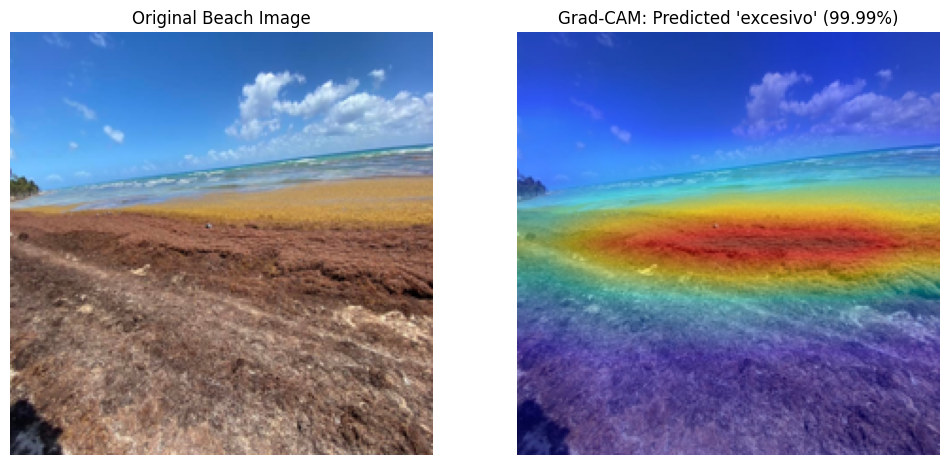

In [17]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# GRAD-CAM CLASS
class SargazoGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hooks to capture forward activations and backward gradients
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)

        # Target the specific class prediction
        loss = output[0, class_idx]
        loss.backward()

        # Weight the activations by the spatial average of the gradients
        grads = self.gradients.cpu().data.numpy()[0]
        weights = np.mean(grads, axis=(1, 2))

        act = self.activations.cpu().data.numpy()[0]
        cam = np.zeros(act.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * act[i, :, :]

        # ReLU and Normalization
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam = cam - np.min(cam)
        cam = (cam / np.max(cam)) if np.max(cam) != 0 else cam
        return cam

# VISUALIZATION FUNCTION
def visualize_results(model, img_path, transform, device, class_names):
    # Load and transform image
    raw_img = Image.open(img_path).convert('RGB')
    input_tensor = transform(raw_img).unsqueeze(0).to(device)

    # Get Prediction
    model.eval()
    output = model(input_tensor)
    pred_idx = torch.argmax(output, 1).item()
    confidence = F.softmax(output, dim=1)[0][pred_idx].item()

    # Initialize Grad-CAM
    # For EfficientNet: model.features[-1]
    # For MobileNet: model.features[-1]
    target_layer = model.features[-1]
    cam_engine = SargazoGradCAM(model, target_layer)

    # Generate Heatmap
    heatmap = cam_engine.generate_heatmap(input_tensor, pred_idx)

    # Create Overlay
    img_cv = np.array(raw_img.resize((input_size, input_size)))
    heatmap_cv = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_cv = cv2.cvtColor(heatmap_cv, cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(img_cv, 0.6, heatmap_cv, 0.4, 0)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_cv)
    plt.title(f"Original Beach Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM: Predicted '{class_names[pred_idx]}' ({confidence:.2%})")
    plt.axis('off')
    plt.show()

# 3. RUN THE ANALYSIS
# Pick an image from the dataset folder
sample_img = os.path.join(IMG_FOLDER, train_df.iloc[6]['image_name'])
class_labels = list(class2id.keys())

visualize_results(model, sample_img, val_transform, device, class_labels)

In [12]:
drive.mount('/content/drive')


checkpoint_path = "/content/drive/My Drive/MEIA2025/sargazo_best_model.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'f1_score': 0.64,
}, checkpoint_path)

print(f"Success! Model persistent at: {checkpoint_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Success! Model persistent at: /content/drive/My Drive/MEIA2025/sargazo_best_model.pth
